# 2-Cell and 3-Cell Motifs in PyC Subgraph (Full)

In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.utils import *
from utils.proximity import *
from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *

### 1. Create PyC Subgraph

In [2]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_soma = pd.read_csv('data/soma.csv')

In [3]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [4]:
locs = {n:string2array(np.array(pyc_soma[pyc_soma["segment_id"] == n]["loc"])[0]) for n in g_actual.nodes()}
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}
nx.set_node_attributes(g_actual, locs, "loc")
nx.set_node_attributes(g_actual, axls, "axl")

In [5]:
g_full = get_thresholded_graph(g_actual, axls, -1)
print(nx.info(g_full))

Name: 
Type: DiGraph
Number of nodes: 363
Number of edges: 1750
Average in degree:   4.8209
Average out degree:   4.8209


### 2. Compare 2-Cell Motif Statistics (OBS vs ER vs CFG)

In [6]:
%%time
# count 2-cell motifs in the observation
obs_two_counts = count_two_neuron_motifs_graph(g_full)
# analytically compute 2-cell motif counts in Erdos-Renyi model
er_two_counts = compute_ER_two_neuron_motifs(g_full)

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.33 ms


In [7]:
%%time
# sample graphs from CFG model and compute 2-cell motif stats for each sample
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_two_counts = sample_motifs_parallel_continuous(continuous_sample_two_neuron_motifs, g_full, samples=s, niters=int(1e4), threads=10)

CPU times: user 124 ms, sys: 68 ms, total: 192 ms
Wall time: 1min 12s


In [8]:
# save sampled motif counts from CFG model as intermediate data
config_two_counts.to_csv("saved/full_2motif_cfg1000.csv", index=False)

In [9]:
# load precomputed sampled motif counts from CFG model
config_two_counts = pd.read_csv("saved/full_2motif_cfg1000.csv")

connect probability =  0.01331750452795154


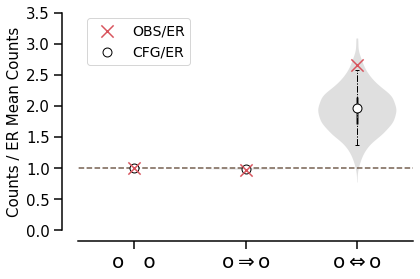

In [13]:
# relative counts in ratio (/ER expected counts)
res_two = plot_two_neuron_counts_violin(obs_two_counts, er_two_counts, config_two_counts, ylim=(0, 3.5), fname="full/full_2_violin");

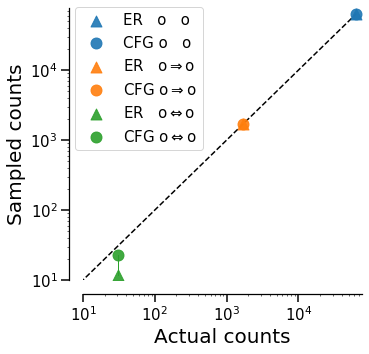

In [14]:
plot_two_neuron_counts_scatter(obs_two_counts, er_two_counts, config_two_counts, figsize=(5,5), fname="full/full_2_scatter")

In [15]:
res_two

,obs,er_exp,config_exp,config_std,proximity_z
actual_edges,NaN,NaN,1750.000,0.000000,NaN
autapses,NaN,NaN,0.000,0.000000,NaN
bi,31.0,11.652816,22.574,4.267873,1.974286
neurons,NaN,NaN,363.000,0.000000,NaN
null,63984.0,63964.652816,63975.574,4.267873,1.974286
potential_edges,NaN,NaN,131406.000,0.000000,NaN
uni,1688.0,1726.694367,1704.852,8.535746,-1.974286


In [16]:
# single side p-values
np.minimum((config_two_counts >= obs_two_counts).sum(0) / 1000, 
           (config_two_counts <= obs_two_counts).sum(0) / 1000)

neurons            1.000
autapses           1.000
actual_edges       1.000
uni                0.035
bi                 0.035
potential_edges    1.000
null               0.035
dtype: float64

### 2. Compare 3-Cell Motif Statistics (OBS vs ER vs CFG)

In [17]:
%%time
# count 3-cell motifs in the observation
obs_three_counts, _ = count_three_neuron_motifs(*graph_to_sets(g_full), motifs)
# analytically compute 2-cell motif counts in Erdos-Renyi model
three_pr, two_pr = compute_three_neuron_motif_probabilities(g_full)
er_three_counts = compute_expected_three_neuron_motifs(g_full, three_pr)

CPU times: user 2min 23s, sys: 272 ms, total: 2min 24s
Wall time: 2min 24s


In [18]:
%%time
# sample graphs from CFG model and compute 3-cell motif stats for each sample
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_three_counts = sample_motifs_parallel_continuous(continuous_sample_three_neuron_motifs, g_full, samples=s, niters=int(1e4), threads=10)

CPU times: user 644 ms, sys: 176 ms, total: 820 ms
Wall time: 7h 11min 35s


In [19]:
# save sampled motif counts from CFG model as intermediate data
config_three_counts.to_csv("saved/full_3motif_cfg1000.csv", index=False)

In [20]:
# load precomputed sampled motif counts from CFG model
config_three_counts = pd.read_csv("saved/full_3motif_cfg1000.csv")
config_three_counts.rename(columns={'{}'.format(k): k for k in range(1,17)}, inplace=True)

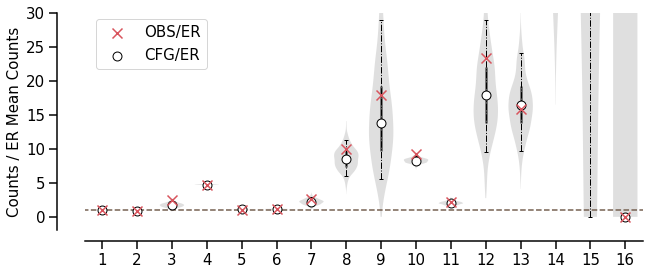

In [47]:
# relative counts in ratio (/ER expected counts)
res_three = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts, config_three_counts, 
                                            subtitle='', ylim=[-2, 30], fname="full/full_3_violin", figsize=(10,4))

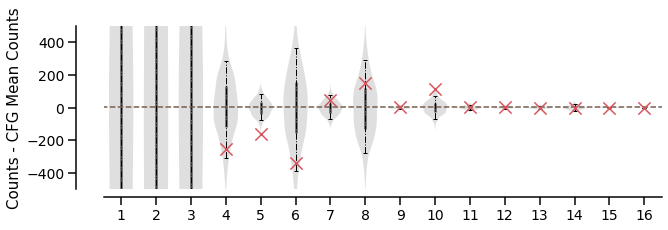

In [22]:
# relative counts in difference (-CFG expected counts)
plot_three_neuron_counts_diff_violin(obs_three_counts, er_three_counts, config_three_counts, 
                                     subtitle='', ylim=[-500, 500], fname="full/full_3_violin_diff");

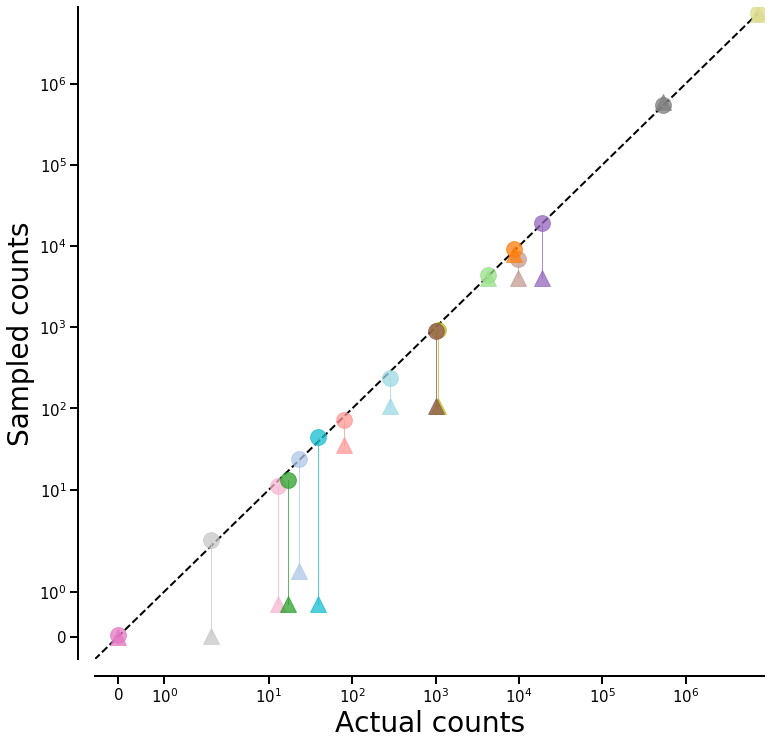

In [23]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts, config_three_counts, figsize=(12,12), fname="full/full_3_scatter")

In [24]:
res_three

,obs,er_exp,config_exp,config_std,config_z
1,7321192,7.295175e+06,7318477.521,1303.620877,2.082261
2,541017,5.907890e+05,546133.735,2402.517570,-2.129739
3,9724,3.987014e+03,6879.201,1312.835467,2.166912
4,18707,3.987014e+03,18960.755,182.816588,-1.388030
5,4267,3.987014e+03,4429.333,50.405941,-3.220513
6,8821,7.974029e+03,9160.930,229.165578,-1.483338
7,287,1.076275e+02,239.039,44.880617,1.068635
8,1071,1.076275e+02,922.552,178.827024,0.830121
9,13,7.263378e-01,11.170,5.420561,0.337603
10,1002,1.076275e+02,890.302,42.347847,2.637631


In [25]:
# one side p-values
np.minimum((config_three_counts >= obs_three_counts).sum(0) / 1000, 
           (config_three_counts <= obs_three_counts).sum(0) / 1000)

1     0.024
2     0.021
3     0.019
4     0.085
5     0.000
6     0.074
7     0.151
8     0.196
9     0.350
10    0.001
11    0.277
12    0.212
13    0.495
14    0.355
15    0.574
16    0.969
dtype: float64

### 3. Compare 3-Cell Motif Statistics (OBS vs gER vs gCFG)

In [26]:
%%time
# analytically compute 2-cell motif counts in generalized Erdos-Renyi model
three_pr_GE, two_pr_GE = compute_three_neuron_motif_probabilities_GE(g_full)
er_three_counts_GE = compute_expected_three_neuron_motifs(g_full, three_pr_GE)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.31 ms


In [27]:
%%time
# sample graphs from generalized CFG (gCFG) model and compute 3-cell motif stats for each sample
s=100 # total 1000 samples (10 workers x 100 continous samples)
config_three_counts_GE = sample_motifs_parallel_continuous(continuous_sample_three_neuron_motifs_GE, g_full, samples=s, niters=int(1e4), threads=10)

CPU times: user 588 ms, sys: 140 ms, total: 728 ms
Wall time: 7h 11min 56s


In [28]:
# save sampled motif counts from gCFG model as intermediate data
config_three_counts_GE.to_csv("saved/full_3motif_gcfg1000.csv", index=False)

In [29]:
# load precomputed sampled motif counts from gCFG model
config_three_counts_GE = pd.read_csv("saved/full_3motif_gcfg1000.csv")
config_three_counts_GE.rename(columns={'{}'.format(k): k for k in range(1,17)}, inplace=True)

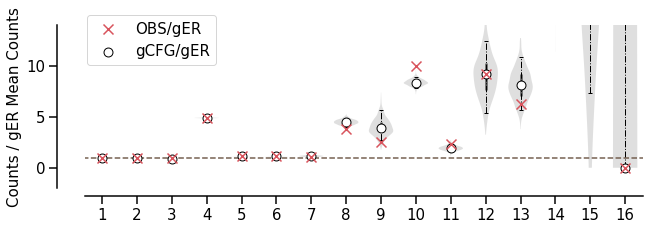

In [44]:
# relative counts in ratio (/ER expected counts)
res_three_GE = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts_GE, config_three_counts_GE, 
                                            subtitle='', ylim=[-2,14], cfg_name="gCFG", er_name="gER",
                                            fname="full/full_3_violin_GE", figsize=(10,3))

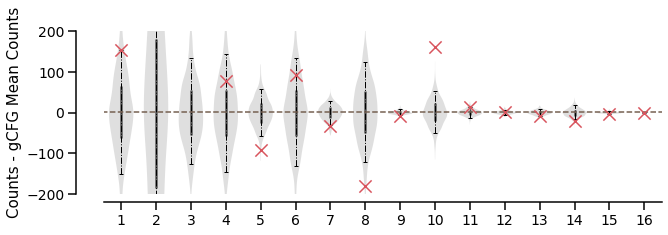

In [31]:
# relative counts in difference (-CFG expected counts)
plot_three_neuron_counts_diff_violin(obs_three_counts, er_three_counts_GE, config_three_counts_GE, cfg_name="gCFG", 
                                     subtitle='', ylim=[-200, 200], fname="full/full_3_violin_diff_GE");

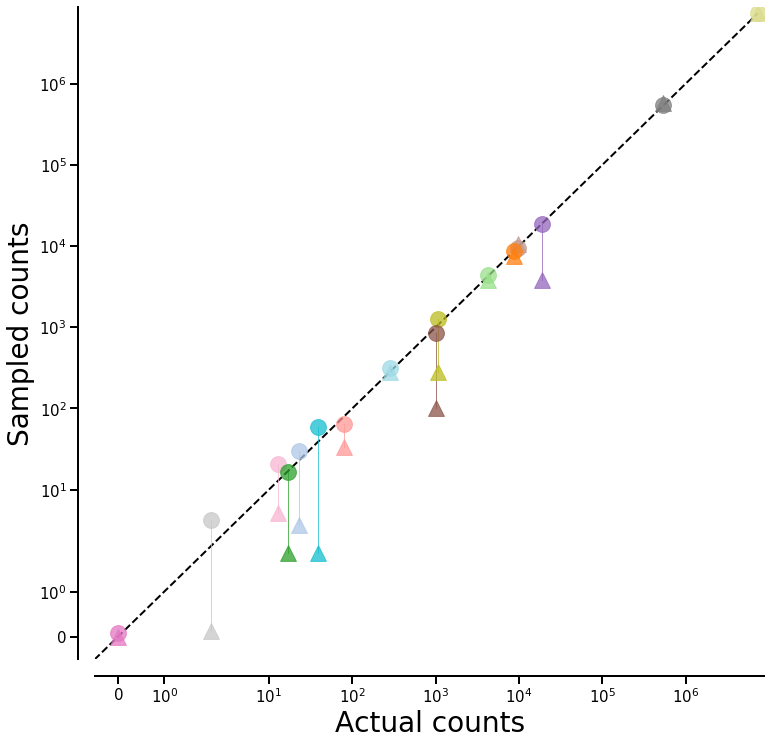

In [32]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts_GE, config_three_counts_GE, 
                                 figsize=(12,12), fname="full/full_3_scatter_GE")

In [33]:
res_three_GE

,obs,er_exp,config_exp,config_std,config_z
1,7321192,7.301796e+06,7321039.478,93.427781,1.632512
2,541017,5.778991e+05,541433.098,268.478955,-1.549835
3,9724,1.061308e+04,9465.486,79.877871,3.236366
4,18707,3.811475e+03,18630.271,86.893360,0.883025
5,4267,3.811475e+03,4358.449,36.187774,-2.527069
6,8821,7.622950e+03,8729.115,84.214261,1.091086
7,287,2.799899e+02,318.884,18.615184,-1.712795
8,1071,2.799899e+02,1251.072,75.217581,-2.394015
9,13,5.141994e+00,20.607,4.543038,-1.674430
10,1002,1.005528e+02,840.009,32.950002,4.916267


In [34]:
# p-values
np.minimum((config_three_counts_GE >= obs_three_counts).sum(0) / 1000, 
           (config_three_counts_GE <= obs_three_counts).sum(0) / 1000)

1     0.053
2     0.057
3     0.003
4     0.189
5     0.005
6     0.139
7     0.045
8     0.009
9     0.043
10    0.000
11    0.052
12    0.517
13    0.130
14    0.021
15    0.221
16    0.917
dtype: float64

### 4. Compare 3-Cell Motif Statistics (OBS vs gER vs CFG)## CFG v.s. Generalized ER

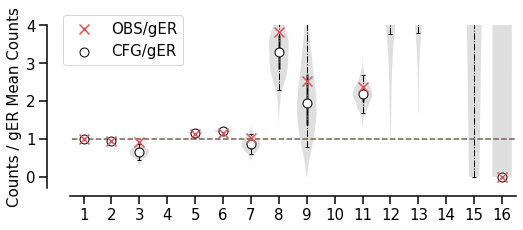

In [35]:
# relative counts in ratio (/ER expected counts)
res_three_CGE = plot_three_neuron_counts_violin(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                            subtitle='', ylim=[-0.3, 4], er_name="gER", fname="full/full_3_violin_CGE", figsize=(8,3))

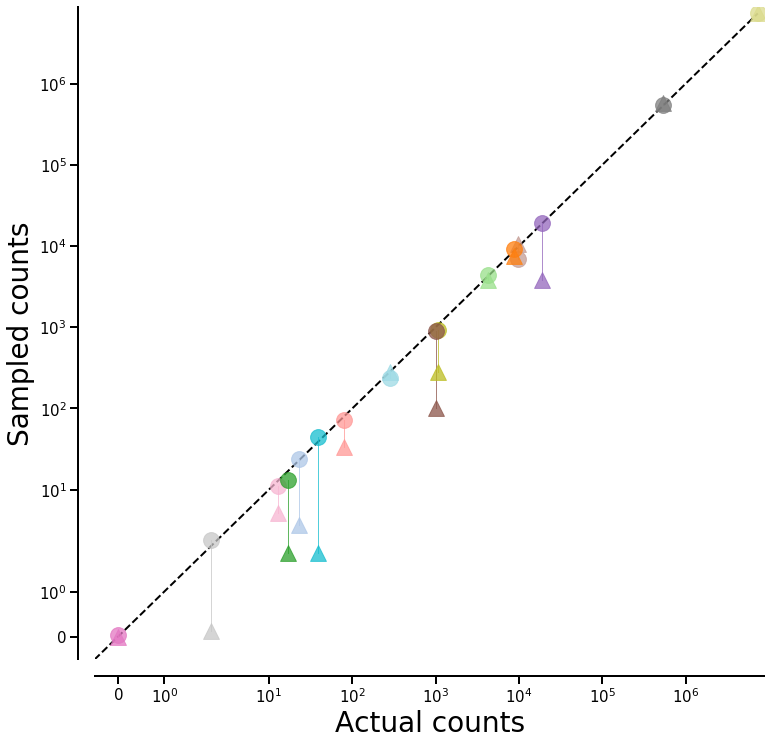

In [36]:
plot_three_neuron_counts_scatter(obs_three_counts, er_three_counts_GE, config_three_counts, 
                                 figsize=(12,12), fname="full/full_3_scatter_CGE")

### 5. Clustering Coefficient

In [37]:
# clustering coefficient of the observed network
nx.transitivity(g_full.to_undirected())

0.09511077158135982

In [38]:
# expected clustering coefficient of the networsk sampled from the ER model
1-two_pr['pr_null']

0.02645765312905113

In [39]:
# expected clustering coefficient of the networsk sampled from the CFG model
clustering_coef(config_three_counts).mean()

0.08517955789223566

In [40]:
# expected clustering coefficient of the networsk sampled from the generalized ER model
1-two_pr_GE['pr_null']

0.02616318889548419

In [41]:
# expected clustering coefficient of the networsk sampled from the generalized CFG model
clustering_coef(config_three_counts_GE).mean()

0.0837260627649594

In [42]:
# p-value: CFG vs OBS
(clustering_coef(config_three_counts) > nx.transitivity(g_full.to_undirected())).sum()/1000

0.0